### Creating connection to databases

In [1]:
from mysql_connection import MySqlManip
from neo4j_connection import Neo4jManip
import pandas as pd
import numpy as np


mysql_conn = MySqlManip(
    user='root', host='10.60.5.99', port=3306, password='Boway@123', database='IOT'
)

neo4j_conn = Neo4jManip(
    uri = "bolt://10.60.5.99:7687",
    user = "neo4j",
    password = "Boway123"
)

# conn.create_params_table()

### Reading network structure from Neo4J

In [2]:
network_graph, sql_info = neo4j_conn.read_bayesian_graph(relationship_type = "Impact")
print(f'''
network_graph: {network_graph},

"sql_info": {sql_info}      
      ''')


network_graph: [('铣面屑料比例', '气泡失效'), ('淘捡材料比例', '气泡失效'), ('浇注温度_3米采样', '气泡失效'), ('浇注温度_开始采样', '气泡失效'), ('新金属材料比例', '气泡失效'), ('除气湿度', '气泡失效'), ('总冷却强度', '气泡失效'), ('外购材料比例', '气泡失效'), ('镁含量', '气泡失效'), ('镍含量', '气泡失效'), ('硅含量', '气泡失效'), ('车间废料比例', '气泡失效'), ('湿度', '气泡失效'), ('进水流量', '气泡失效'), ('浇注温度_5米采样', '气泡失效'), ('锌含量', '气泡失效'), ('铝含量', '气泡失效')],

"sql_info": {'table_name': 'device_4_bubble_cleaned_data_bayes', '铣面屑料比例': {'type': 'factor', 'sql_column': 'weight_percent_ximianxueliao', 'upper': '100', 'lower': '0'}, '气泡失效': {'type': 'target', 'sql_column': 'label'}, '淘捡材料比例': {'type': 'factor', 'sql_column': 'weight_percent_pick', 'upper': '100', 'lower': '0'}, '浇注温度_3米采样': {'type': 'factor', 'sql_column': 'temp_3m_jiaozhu', 'upper': '1270', 'lower': '1230'}, '浇注温度_开始采样': {'type': 'factor', 'sql_column': 'temp_jiaozhu', 'upper': '1270', 'lower': '1230'}, '新金属材料比例': {'type': 'factor', 'sql_column': 'weight_percent_new_metal', 'upper': '100', 'lower': '0'}, '除气湿度': {'type': 'factor', 'sql_colu

### Reading structured data from MySQL

In [3]:
raw_data = mysql_conn.load_data_to_dataframe(sql_info["table_name"])
raw_data = raw_data.dropna()
raw_data = raw_data[[sql_info[variable]["sql_column"] for variable in sql_info.keys() if variable != "table_name"]]
raw_data.columns = [variable for variable in sql_info.keys() if variable != "table_name"]


Data augument

In [95]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# kde = IterativeImputer(max_iter=10, random_state=0)
# kde.fit(raw_data)

# seed = [[None for x in range(18)]]
# seed[0][1] = 0
# pd.concat([pd.DataFrame(kde.transform(seed), columns=raw_data.columns), raw_data.iloc[[2000]]])

c:\Users\pw\Downloads\KG_to_BN\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but IterativeImputer was fitted with feature names
  warnings.warn(


,铣面屑料比例,气泡失效,淘捡材料比例,浇注温度_3米采样,浇注温度_开始采样,新金属材料比例,除气湿度,总冷却强度,外购材料比例,镁含量,镍含量,硅含量,车间废料比例,湿度,进水流量,浇注温度_5米采样,锌含量,铝含量
0,0.106146,0.0,0.000115,1238.770098,1240.216455,0.146195,59.970727,1925.102770,0.030513,0.092892,2.544802,0.540436,0.700612,59.970727,18.547294,1235.081799,0.027498,0.002663
2000,0.138447,0.0,0.002894,1237.000000,1240.000000,0.221418,63.200000,1558.350215,0.000000,0.0087,1.895000,0.377100,0.637241,63.200000,19.543176,1234.000000,0.0248,0.0052


In [4]:
raw_data = mysql_conn.load_data_to_dataframe(sql_info["table_name"])
raw_data = raw_data.dropna()
series = []

for variable in sql_info.keys():
    if variable == "table_name":
        continue
    ser = raw_data[sql_info[variable]["sql_column"]]
    ser.name = variable
    if sql_info[variable]["type"] == "target":
        ser = pd.cut(
            ser, 
            2,
            labels=["FineBatch", "BadBatch"])
    else:
        try:
            ser = pd.cut(
                ser.astype('float'), 
                [-float("inf"), 
                float(sql_info[variable]["lower"]), 
                float(sql_info[variable]["upper"]),
                float("inf")],
                labels=["lower", "medium", "upper"])
        except Exception as e:
            print(f"{variable}: {e}")
    series.append(ser)

data = pd.DataFrame(series).T
data


,铣面屑料比例,气泡失效,淘捡材料比例,浇注温度_3米采样,浇注温度_开始采样,新金属材料比例,除气湿度,总冷却强度,外购材料比例,镁含量,镍含量,硅含量,车间废料比例,湿度,进水流量,浇注温度_5米采样,锌含量,铝含量
0,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,lower,medium,medium,upper
1,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,lower,medium,medium,upper
2,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,lower,medium,medium,upper
3,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,lower,medium,medium,upper
4,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,lower,medium,medium,upper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16208,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,medium,medium,medium,upper
16209,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,medium,medium,medium,upper
16210,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,medium,medium,medium,upper
16211,medium,FineBatch,lower,medium,medium,medium,lower,lower,lower,medium,medium,medium,medium,upper,medium,medium,medium,upper


### Creating model

In [16]:
from models.bayes_net import BNCreator
model = BNCreator(network_graph, node_info = sql_info)
# model.to_graphviz()

In [6]:
from pgmpy.factors.discrete import TabularCPD

Creating index : label mapping for different features

In [7]:
list_evidences = [x for x in list(model.nodes) if x != '气泡失效']

node_name_decoding = {
    i: list_evidences[i] for i in range(len(list_evidences))
}
node_name_encoding = {
    list_evidences[i]: i for i in range(len(list_evidences))
}

node_class_decoding = {}
node_class_encoding = {}
for node in list(model.nodes):
    node_classes = list(set(data[node]))
    node_class_decoding[node] = {i: node_classes[i] for i in range(len(node_classes))}
    node_class_encoding[node] = {node_classes[i]: i for i in range(len(node_classes))}

Changing column names

In [8]:
data_1 = data
for col in data_1:
    data_1[col] = data_1[col].replace(node_class_encoding[col])

Training model

In [9]:
list_tier1_evidences = []
for edge in list(model.edges()):
    if edge[1] == '气泡失效':
        list_tier1_evidences.append(edge[0])

In [10]:
list_tier2_evidences = []
for edge in list(model.edges()):
    if edge[1] == '总冷却强度':
        list_tier2_evidences.append(edge[0])

In [11]:
cpd_target = TabularCPD(
    variable = '气泡失效',
    variable_card = len(node_class_encoding['气泡失效']),
    evidence = list_tier1_evidences,
    evidence_card = [len(node_class_encoding[x]) for x in list_tier1_evidences],
    values = [
        [0.92 for i in range(np.prod([len(node_class_encoding[x]) for x in list_tier1_evidences]))],
        [0.08 for i in range(np.prod([len(node_class_encoding[x]) for x in list_tier1_evidences]))]
    ]
)

In [12]:
node_class_encoding['气泡失效']['FineBatch'] = 0
node_class_encoding['气泡失效']['BadBatch'] = 1
node_class_decoding['气泡失效'][1] = 'BadBatch'
node_class_decoding['气泡失效'][0] = 'FineBatch'


In [13]:
second_tier = False
try:
    cpd_middle = TabularCPD(
        variable = '总冷却强度',
        variable_card = len(node_class_encoding['总冷却强度']),
        evidence = list_tier2_evidences,
        evidence_card = [len(node_class_encoding[x]) for x in list_tier2_evidences],
        values = [
            [0.01 for i in range(np.prod([len(node_class_encoding[x]) for x in list_tier2_evidences]))],
            [0.05 for i in range(np.prod([len(node_class_encoding[x]) for x in list_tier2_evidences]))],
            [0.94 for i in range(np.prod([len(node_class_encoding[x]) for x in list_tier2_evidences]))]
        ]
    )
    second_tier = True
except TypeError as e:
    if "'numpy.float64' object cannot be interpreted as an integer" in str(e):
        print("no second tier evidences appeared")
except Exception as err:
    print(f"error happens: {err}")

no second tier evidences appeared


In [22]:
model.fit(data_1)
model.add_cpds(cpd_target)
if second_tier:
    model.add_cpds(cpd_middle)
model.fit_update(pd.concat([data_1]))

In [23]:
# 输出气泡直接相关的后验概率 —— 直接输出

import numpy as np

for col in data.columns:
    
    if col == '气泡失效':
        continue
    
    source_node = col
    target_node = '气泡失效'
    conditions = list(node_class_decoding[source_node].keys())
    
    decode_target = {
        '''%s_%s'''%(target_node, str(i)): '''%s_%s'''%(target_node, node_class_decoding['气泡失效'][i]) \
            for i in node_class_decoding['气泡失效']
    }

    df_prob = model.predict_probability(pd.DataFrame.from_dict({source_node: conditions}))[[
        '气泡失效_0', '气泡失效_1']].rename(columns=decode_target)
    df_prob[source_node] = [node_class_decoding[source_node][conditions[i]] for i in range(len(conditions))]
    
    print (df_prob)
        

   气泡失效_FineBatch  气泡失效_BadBatch  铣面屑料比例
0        0.905310       0.094690  medium
1        0.918067       0.081933   lower
   气泡失效_FineBatch  气泡失效_BadBatch  淘捡材料比例
0        0.919226       0.080774  medium
1        0.906901       0.093099   lower
   气泡失效_FineBatch  气泡失效_BadBatch 浇注温度_3米采样
0        0.907148       0.092852    medium
1        0.919993       0.080007     lower
   气泡失效_FineBatch  气泡失效_BadBatch 浇注温度_开始采样
0        0.907214       0.092786    medium
1        0.919997       0.080003     lower
   气泡失效_FineBatch  气泡失效_BadBatch 新金属材料比例
0        0.904969       0.095031  medium
1        0.913830       0.086170   lower
   气泡失效_FineBatch  气泡失效_BadBatch   除气湿度
0        0.907472       0.092528  lower
   气泡失效_FineBatch  气泡失效_BadBatch   总冷却强度
0        0.919947       0.080053   upper
1        0.919130       0.080870  medium
2        0.906843       0.093157   lower
   气泡失效_FineBatch  气泡失效_BadBatch  外购材料比例
0        0.919889       0.080111  medium
1        0.906127       0.093873   lower
   气泡失

In [15]:
# 输出气泡直接相关的后验概率 —— 假设其他code都服从经验分布

# import numpy as np

# for col in data.columns:
    
#     if col == '气泡失效':
#         continue
    
#     source_node = col
#     target_node = '气泡失效'
#     conditions = list(node_class_decoding[source_node].keys())
    
#     decode_target = {
#         '''%s_%s'''%(target_node, str(i)): '''%s_%s'''%(target_node, node_class_decoding['气泡失效'][i]) \
#             for i in node_class_decoding['气泡失效']
#     }

#     data_2 = data_1
#     data_2 = data_2.drop('气泡失效', axis='columns')
    
#     df_prob = model.predict_probability(data_2)
#     df_prob[source_node] = data_2[source_node]
#     df_g = df_prob.groupby(source_node).agg({'气泡失效_0': np.mean, '气泡失效_1': np.mean}).\
#         rename(columns=decode_target).reset_index(drop=False)
#     df_g[source_node] = df_g[source_node].replace(node_class_decoding[source_node])

#     print (df_g)

In [20]:
# 输出所有edge（egde for BN = relation for KG）的后验概率

dic_posterior = {}

for edge in list(model.edges):
    source_node = edge[0]
    target_node = edge[1]
    data_2 = data_1
    data_2 = data_2.drop(target_node, axis='columns')
    target_classes = list(node_class_decoding[target_node].keys())
    target_group_method = {
        (target_node + '_' + str(x)): np.mean for x in target_classes
    }
    decode_target = {
        '''%s_%s'''%(target_node, str(i)): '''%s_%s'''%(target_node, node_class_decoding[target_node][i]) \
            for i in node_class_decoding[target_node]
    }
    df_prob = model.predict_probability(data_2)
    df_prob[source_node] = data_2[source_node]
    df_g = df_prob.groupby(source_node).agg(target_group_method).\
        rename(columns=decode_target).reset_index(drop=False)
    df_g[source_node] = df_g[source_node].replace(node_class_decoding[source_node])
    
    dic_posterior[(source_node, target_node)] = {
        df_g[source_node][i]: {
            col: df_g[col][i] for col in list(df_g.columns) if col != source_node
            } for i in range(len(df_g))
    }
    

In [21]:
dic_posterior

{('铣面屑料比例',
  '气泡失效'): {'lower': {'气泡失效_FineBatch': 0.9043054938710274,
   '气泡失效_BadBatch': 0.09569450612897264}, 'medium': {'气泡失效_FineBatch': 0.8806043541716132,
   '气泡失效_BadBatch': 0.11939564582838681}},
 ('淘捡材料比例',
  '气泡失效'): {'lower': {'气泡失效_FineBatch': 0.8833090558321672,
   '气泡失效_BadBatch': 0.1166909441678328}, 'medium': {'气泡失效_FineBatch': 0.9116499928078051,
   '气泡失效_BadBatch': 0.0883500071921949}},
 ('浇注温度_3米采样',
  '气泡失效'): {'lower': {'气泡失效_FineBatch': 0.9172935360402595,
   '气泡失效_BadBatch': 0.08270646395974054}, 'medium': {'气泡失效_FineBatch': 0.8837766315871072,
   '气泡失效_BadBatch': 0.11622336841289278}},
 ('浇注温度_开始采样',
  '气泡失效'): {'lower': {'气泡失效_FineBatch': 0.917312840934356,
   '气泡失效_BadBatch': 0.08268715906564403}, 'medium': {'气泡失效_FineBatch': 0.8839492313711875,
   '气泡失效_BadBatch': 0.11605076862881254}},
 ('新金属材料比例',
  '气泡失效'): {'lower': {'气泡失效_FineBatch': 0.8976939688022768,
   '气泡失效_BadBatch': 0.10230603119772316}, 'medium': {'气泡失效_FineBatch': 0.8794743632278692,
   '气泡失效_

Writing values to edges of KG

In [24]:
for start_end, matrix in dic_posterior.items():
    start = start_end[0]
    end = start_end[1]
    neo4j_conn.update_relationship(
        start_name = start, 
        end_name = end, 
        key = "probabilities", 
        content = matrix
    )


NameError: name 'dic_posterior' is not defined

In [5]:
# from pgmpy.estimators import ExpectationMaximization

# estimator = ExpectationMaximization(model, data)
# latent_card = {}
# for latent_node in latents:
#     latent_card[latent_node] = 10
# params = estimator.get_parameters(latent_card = latent_card)
# model.add_cpds(*params)

# model.fit(data)

### Making inference

In [39]:
sample_data = data.drop(columns=["气泡失效"]).loc[[499]]

model.predict_probability(sample_data)

,气泡失效_0,气泡失效_1
499,0.914234,0.085766


### Input interface

In [40]:
res = model.make_inference({"气泡失效": 0, "镁含量": 0.0, "车间废料比例": 90.0}, target="")

print(res)

KeyError: 'FineBatch'

### Result values write to databases

In [41]:
for key, value in res.items():
    neo4j_conn.update_node(
        key, "probablities", str(value)
    )
    if value.get('medium') and value.get('medium') < 0.5:
        neo4j_conn.add_node_type(key, "activate")

NameError: name 'res' is not defined

In [9]:
for key, value in res.items():
    neo4j_conn.remove_node_type(key, "activate")

In [42]:
print(model.get_cpds()[4])

+--------------+-----------+
| 浇注温度_开始采样(0) | 0.0201073 |
+--------------+-----------+
| 浇注温度_开始采样(1) | 0.979893  |
+--------------+-----------+


In [43]:
model.get_cpds()

[<TabularCPD representing P(铣面屑料比例:2) at 0x25ff464b790>,
 <TabularCPD representing P(气泡失效:2 | 外购材料比例:2, 总冷却强度:3, 新金属材料比例:2, 浇注温度_3米采样:2, 浇注温度_5米采样:2, 浇注温度_开始采样:2, 淘捡材料比例:2, 湿度:2, 硅含量:3, 车间废料比例:2, 进水流量:3, 铝含量:3, 铣面屑料比例:2, 锌含量:1, 镁含量:2, 镍含量:3, 除气湿度:1) at 0x25ff879e650>,
 <TabularCPD representing P(淘捡材料比例:2) at 0x25ff879cf90>,
 <TabularCPD representing P(浇注温度_3米采样:2) at 0x25f93b2fe50>,
 <TabularCPD representing P(浇注温度_开始采样:2) at 0x25f93b2e2d0>,
 <TabularCPD representing P(新金属材料比例:2) at 0x25f93b2d050>,
 <TabularCPD representing P(除气湿度:1) at 0x25f93b2ce50>,
 <TabularCPD representing P(总冷却强度:3) at 0x25f93b2cc10>,
 <TabularCPD representing P(外购材料比例:2) at 0x25f93b2ca50>,
 <TabularCPD representing P(镁含量:2) at 0x25f93b2c8d0>,
 <TabularCPD representing P(镍含量:3) at 0x25f93b2c610>,
 <TabularCPD representing P(硅含量:3) at 0x25f93b2c410>,
 <TabularCPD representing P(车间废料比例:2) at 0x25f93b2c210>,
 <TabularCPD representing P(湿度:2) at 0x25f93b2d0d0>,
 <TabularCPD representing P(进水流量:3) at 0x25f93b2ff10>,
 

In [44]:
import numpy as np

for col in data.columns:
    
    if col == '气泡失效':
        continue
    
    source_node = col
    set_source_classes = set(data[source_node])
    conditions = []
    if 0 in set_source_classes:
        conditions.append(0)
    if 1 in set_source_classes:
        conditions.append(1)
    if 2 in set_source_classes:
        conditions.append(2)

    df_prob = model.predict_probability(pd.DataFrame.from_dict({source_node: conditions}))[[
        '气泡失效_0', '气泡失效_1']]
    df_prob[source_node] = conditions
    
    print (df_prob)
        

     气泡失效_0    气泡失效_1  铣面屑料比例
0  0.920168  0.079832       0
1  0.919856  0.080144       1
     气泡失效_0    气泡失效_1  淘捡材料比例
0  0.919903  0.080097       0
1  0.920017  0.079983       1
     气泡失效_0    气泡失效_1  浇注温度_3米采样
0  0.920001  0.079999          0
1  0.919906  0.080094          1
     气泡失效_0    气泡失效_1  浇注温度_开始采样
0  0.920000  0.080000          0
1  0.919907  0.080093          1
     气泡失效_0    气泡失效_1  新金属材料比例
0  0.920327  0.079673        0
1  0.919744  0.080256        1
     气泡失效_0    气泡失效_1  除气湿度
0  0.919909  0.080091     0
     气泡失效_0    气泡失效_1  总冷却强度
0  0.919900  0.080100      0
1  0.920005  0.079995      1
2  0.920074  0.079926      2
     气泡失效_0    气泡失效_1  外购材料比例
0  0.919898  0.080102       0
1  0.920010  0.079990       1
     气泡失效_0    气泡失效_1  镁含量
0  0.920085  0.079915    0
1  0.919885  0.080115    1
     气泡失效_0    气泡失效_1  镍含量
0  0.919990  0.080010    0
1  0.920327  0.079673    1
2  0.919229  0.080771    2
     气泡失效_0    气泡失效_1  硅含量
0  0.919902  0.080098    0
1  0.920328  0.079672   

In [51]:
df_prob.columns

Index(['气泡失效_BadBatch', '气泡失效_FineBatch', '镍含量'], dtype='object')

In [38]:
data.groupby(['气泡失效']).agg({'气泡失效':'count'})

,气泡失效
气泡失效,
0,14905
1,1308


In [39]:
1308 / (1308 + 14905)

0.0806760007401468

In [2]:
from pomegranate.distributions import Categorical
from pomegranate.distributions import ConditionalCategorical
from pomegranate.bayesian_network import BayesianNetwork

d1 = Categorical([[0.1, 0.9]])
d2 = ConditionalCategorical([[[0.4, 0.6], [0.3, 0.7]]])

model = BayesianNetwork([d1, d2], [(d1, d2)])

[bnlearn] >Import <sprinkler>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+--------+-----------+
|    |   Rain |         p |
+====+========+===========+
|  0 |      0 | 0.0241546 |
+----+--------+-----------+
|  1 |      1 | 0.975845  |
+----+--------+-----------+
   Rain         p
0     0  0.024155
1     1  0.975845
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Cloudy:
+-----------+---------------------+--------------------+
| Wet_Grass | Wet_Grass(0)        | Wet_Grass(1)       |
+-----------+---------------------+---------------

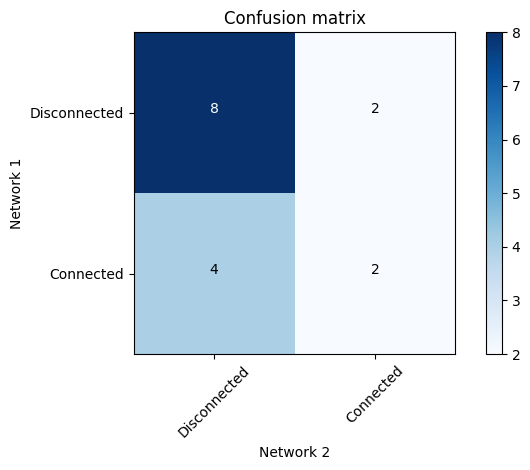

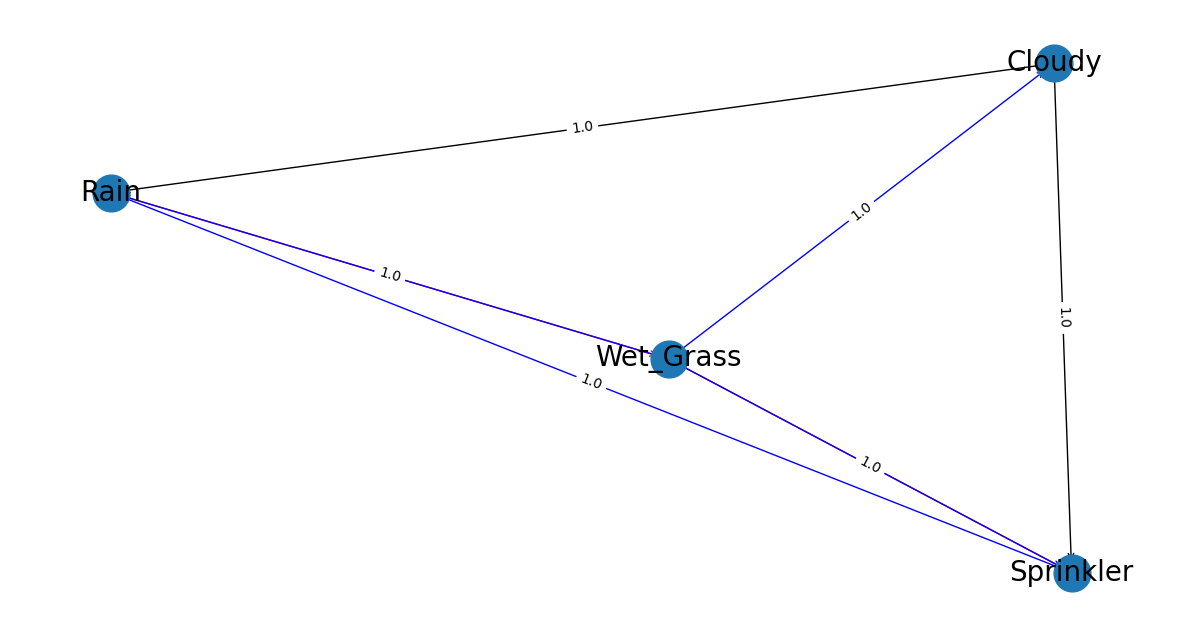

In [1]:
import bnlearn as bn

model = bn.import_DAG('sprinkler')

df = bn.import_example()

df = bn.sampling(model)

query = bn.inference.fit(model, variables=['Rain'], evidence={'Cloudy':1, 'Wet_Grass':1})
print(query.df)

model_sl = bn.structure_learning.fit(df)

model_pl = bn.parameter_learning.fit(model_sl, df)

scores, adjmat = bn.compare_networks(model_sl, model)

In [2]:
import bnlearn as bn

In [7]:
query = bn.inference.fit(model, variables=['Rain'], evidence={'Cloudy':1, 'Wet_Grass':1})
print(query.df)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+--------+-----------+
|    |   Rain |         p |
+====+========+===========+
|  0 |      0 | 0.0241546 |
+----+--------+-----------+
|  1 |      1 | 0.975845  |
+----+--------+-----------+
   Rain         p
0     0  0.024155
1     1  0.975845
